In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

RDKit WARNING: [00:04:55] Enabling RDKit 2020.03.1dev1 jupyter extensions


'/net/pulsar/home/koes/mtr22/gan'

In [2]:
def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return dt.timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds).days

def get_palette(n_hues, n_shades=1, n_repeat=1, hues=None, min_val=0.0, max_val=1.0, n_samples=100, mode=None):
    assert 0 <= min_val <= 1.0
    assert 0 <= max_val <= 1.0
    
    if hues is None:
        if n_hues <= 9:
            mode = mode or 'muted'
            hues = sns.color_palette(mode)[:n_hues]
        else:
            mode = mode or 'husl'
            hues = sns.color_palette(mode, n_hues)
            
    if not isinstance(n_shades, list):
        n_shades = [n_shades] * len(hues)

    colors = []
    for hue, n_shades in zip(hues, n_shades):
        
        # get n_samples different shades of hue
        shades = (
            sns.dark_palette(hue, n_colors=n_samples//2) + \
            sns.light_palette(hue, n_colors=n_samples//2, reverse=True)
        )
        # limit shade range with min_val and max_val
        min_idx = int(min_val * len(shades))
        max_idx = int(max_val * len(shades))
        shades = shades[min_idx:max_idx]
        
        # get n_shades evenly spaced shades in that range, avoiding endpoints
        vals = np.linspace(0, 1, n_shades + 2)
        idxs = [int(v * (len(shades) - 1)) for v in vals]
        shades = [shades[i] for i in idxs[1:-1]]
        
        # repeat each shade n_repeat times
        shades = sorted(n_repeat * shades, key=lambda x: sum(x))

        colors.extend(shades)
        
    return sns.color_palette(colors)

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')

get_palette(n_hues=5, n_shades=[1,2,3,4,5], mode='bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (0.7303055126922927, 0.37401705098309446, 0.043187573664151865),
 (0.9844773267701052, 0.6343974503939503, 0.3054485381797389),
 (0.11765447059964117, 0.4644768631663434, 0.17588467018778384),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.5030029764381416, 0.8687267017335306, 0.563760629977106),
 (0.4706802763783887, 0.0814431506173033, 0.0983586076494307),
 (0.7634293731718812, 0.027147716872434446, 0.06154437248445076),
 (0.9176295076475914, 0.17345829730976864, 0.2086305836444825),
 (0.9349456981201926, 0.557280912633512, 0.574828587670488),
 (0.28221917951149533, 0.1502744739281356, 0.4109591598393532),
 (0.4182437057537802, 0.1597710725191288, 0.6569072188326472),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6752846353959335, 0.42043142881142276, 0.9073661857993561),
 (0.8070397447831716, 0.6752691895078875, 0.928711978373049)]

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [ ]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [ ]:
line_idx, n_lines, pct_done

In [ ]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [ ]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
os.chdir(add_expt_dir)
os.getcwd()

In [ ]:
add_params = param_search.ParamSpace(
    data_root = '/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file = '/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples = 100000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol = [0, 1],
    remove_h = [0, 1],
)
len(add_params)

In [ ]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

In [ ]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

In [ ]:
add_df = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

In [ ]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['remove_h'] == 0) &
    (plot_df['typer_fns'] == 'on')
]
plot_df.groupby(
    ['use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

In [ ]:
typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        'smi_match',
        'valid_smi_match',
        'lig_add_valid',
        'rd_sim',
        'ob_sim',
        'add_time'
    ],
    hue=None,
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=sns.barplot,
    ylim=dict(
        exact_elems=[0, 1],
        exact_props=[0, 1],
        exact_n_atoms=[0, 1],
        smi_match=[0, 1],
        lig_valid=[0, 1],
        lig_add_valid=[0, 1],
        valid_smi_match=[0, 1],
        rd_sim=[0, 1],
        ob_sim=[0, 1],
    )
)

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'onc', 'oh']
))

In [ ]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

In [ ]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

In [ ]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

In [ ]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

In [ ]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

In [ ]:
fit_df = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

In [ ]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

In [ ]:
def my_plot(*args, **kwargs):
    return sns.barplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [ ]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids, then test molecule reconstruction using atom fitting + bond adding.

[Table of contents](#Table-of-contents)

In [182]:
train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [4]:
%%time
import param_search
gen_params = param_search.ParamSpace(
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    
    # typer params
    typer_fns=['on', 'oadc'],
    use_rec_elems=True,
    radius_fn=1.0,
    
    # gen model params
    gen_init_conv_pool=0,
    gen_conv_per_level=[3, 4, 5],
    gen_block_type='c',
    gen_n_filters=[16, 24, 32, 48, 64],
    gen_spectral_norm=[0, 1],
    n_latent=[64, 128, 256, 512],
    
    # loss fn params
    kldiv_loss_wt=[0.5, 1.0, 2.0],
    recon_loss_wt=[0.5, 1.0, 2.0],

    # optimizer params
    optim_type=['RMSprop'],
    gen_lr=[5e-6, 1e-5, 2e-5],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    
    # other stuff
    group_name='3',
    sbatch_line=' ', #'#SBATCH -C M16',
    gen_iteration=100000,
)
cvae_params = param_search.ParamSpace( # CVAE has no discriminator
    model_type='CVAE',
    disc_init_conv_pool=0,
    disc_conv_per_level=0,
    disc_block_type='c',
    disc_n_filters=0,
    n_disc_train_iters=0,
    disc_lr=0.0,
    gan_loss_wt=0.0,
)
cgan_params = param_search.ParamSpace( # CVAEGAN disc model/loss/optim params
    model_type='CVAEGAN',
    disc_init_conv_pool=[0, 1],
    disc_conv_per_level=[3, 4, 5],
    disc_block_type='c',
    disc_n_filters=[16, 24, 32, 48, 64],
    n_disc_train_iters=[1, 2, 4],
    disc_lr=[5e-5, 1e-4, 2e-4],
    gan_loss_wt=[0.5, 1.0, 2.0],
)

train_params = gen_params * (
    len(cgan_params)*cvae_params + len(cvae_params)*cgan_params
)

name_format = 'train{group_name}_{model_type}_{typer_fns}_' \
    '{gen_init_conv_pool}_{gen_conv_per_level}_{gen_block_type}_{gen_n_filters}_{gen_spectral_norm}_{n_latent}_' \
    '{disc_init_conv_pool}_{disc_conv_per_level}_{disc_block_type}_{disc_n_filters}_' \
    '{kldiv_loss_wt}_{recon_loss_wt}_{gan_loss_wt}_{gen_lr:.1e}_{disc_lr:.1e}_' \
    '{n_disc_train_iters}_{random_seed}'

CPU times: user 5.74 ms, sys: 0 ns, total: 5.74 ms
Wall time: 5.72 ms


In [102]:
import param_search

base_params = param_search.ParamSpace(
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    batch_size=[8, 10],
    
    # typer params
    typer_fns='oadc',
    use_rec_elems=True,
    radius_fn=1.0,
    
    # gen model params
    gen_n_filters=[16, 20, 24, 28, 32, 32],
    gen_conv_per_level=[3, 4],
    bn_factor=[0, 4],
    gen_spectral_norm=1,
    n_latent=128,
    skip_connect=True,
    
    # loss fn params
    kldiv_loss_wt=[0.1, 0.2, 0.4, 0.8],
    recon_loss_wt=[1.0, 2.0, 4.0, 8.0],
    steric_loss_wt=[0.0, 0.0, 0.0, 0.5, 1.0, 2.0],

    # optimizer params
    optim_type=['RMSprop'],
    gen_lr=[5e-6, 1e-5, 2e-5],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    
    # other stuff
    group_name='4',
    gen_k_iter=100,
    random_seed=range(100),
)

pool0_params = param_search.ParamSpace( # no init_conv_pool
    gen_init_conv_pool=0,
    gen_n_levels=4,
)
pool1_params = param_search.ParamSpace( # yes init_conv_pool
    gen_init_conv_pool=1,
    gen_n_levels=3,
)

dense0_params = param_search.ParamSpace( # no dense net
    block_type=['c', 'r'],
    growth_rate=0,
    width_factor=2,
)
dense1_params = param_search.ParamSpace( # yes dense net
    block_type='d',
    growth_rate=[4, 8, 16],
    width_factor=[1, 2],
) 

gan0_params = param_search.ParamSpace( # no GAN
    model_type='CVAE',
    disc_init_conv_pool=0,
    disc_n_levels=0,
    disc_conv_per_level=0,
    disc_n_filters=0,
    n_disc_train_iters=0,
    disc_lr=0.0,
    gan_loss_wt=0.0,
    sbatch_line=' ',
)
gan1_params = param_search.ParamSpace( # yes GAN
    model_type='CVAEGAN',
    disc_init_conv_pool=1,
    disc_n_levels=[3, 4],
    disc_conv_per_level=[3, 4, 5],
    disc_n_filters=[16, 20, 24, 28, 32, 32],
    n_disc_train_iters=1,
    disc_lr=[5e-5, 1e-4, 2e-4],
    gan_loss_wt=[0.5, 1.0, 2.0],
    sbatch_line='#SBATCH -C M12',
)

train_params = base_params * (
    len(pool1_params)*pool0_params + len(pool0_params)*pool1_params
) * (
    len(dense1_params)*dense0_params + len(dense0_params)*dense1_params
) * (
    len(gan1_params)*gan0_params + len(gan0_params)*gan1_params
)

name_format = 'train{group_name}_{model_type}_' \
    '{block_type}{width_factor}{growth_rate}{bn_factor}_' \
    'G{gen_n_filters}{gen_n_levels}{gen_conv_per_level}_{gen_lr:.1e}_' \
    'D{disc_n_filters}{disc_n_levels}{disc_conv_per_level}_{disc_lr:.1e}_' \
    'L{kldiv_loss_wt}-{recon_loss_wt}-{steric_loss_wt}-{gan_loss_wt}' \
    '_{random_seed}'

len(train_params)

42998169600

In [ ]:
import random
random.seed(0)
np.random.seed(0)

sample = train_params.sample(100, replace=False)

sampled_params = []
for p in sample:
    #for s in np.random.permutation(100)[:3]:
        #p = p.copy()
        #p['random_seed'] = s
    sampled_params.append(p)
    print(name_format.format(**p))


In [ ]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sampled_params,
    )

train_job_files

In [ ]:
job_ids = param_search.submit(train_job_files)
print(job_ids)

In [183]:
train_jobs = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit (held most CVAEGANs and CGANs to allow full data jobs)
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],

        # BUG STARTS HERE- switched from lig elems to rec elems (for rec AND lig)
        # train2- resubmit all jobs, training to 200k- these did not have continue set, so they started from 0
        #[6837351, 6837352, 6837353, 6837354, 6837355, 6837356, 6837357, 6837358, 6837359, 6837360, 6837361, 6837362, 6837363, 6837364, 6837365, 6837366, 6837367, 6837368, 6837369, 6837370, 6837371, 6837372, 6837373, 6837374],

        # train2- let's try that again
        [6837376, 6837377, 6837378, 6837379, 6837380, 6837381, 6837382, 6837383, 6837384, 6837385, 6837386, 6837387, 6837388, 6837389, 6837390, 6837391, 6837392, 6837393, 6837394, 6837395, 6837396, 6837397, 6837398, 6837399],

        # train1- released jobs tried to continue from iter 0, but no metrics file was found. add try-except to ignore this
        [6837497, 6837498, 6837499, 6837500, 6837501, 6837502, 6837503, 6837504, 6837505, 6837506, 6837507, 6837508, 6837509, 6837510, 6837511, 6837512, 6837513, 6837514, 6837515, 6837516, 6837517, 6837518, 6837519, 6837520, 6837521, 6837522, 6837523, 6837524, 6837525, 6837526, 6837527, 6837528, 6837529, 6837530, 6837531, 6837532, 6837533, 6837534, 6837535, 6837536, 6837537, 6837538, 6837539, 6837540, 6837541, 6837542, 6837543, 6837544, 6837545, 6837546, 6837547, 6837548],

        # train2- train full data CVAEs to 300k
        [6837556, 6837557, 6837558, 6837559, 6837560, 6837561, 6837562, 6837563, 6837564, 6837565, 6837566, 6837567, 6837568, 6837569, 6837570, 6837571, 6837572, 6837573, 6837574, 6837575, 6837576, 6837577, 6837578, 6837579],

        # train2- manually resubmitted with fixed SBATCH -c M16 due to cuda oom (expecting more...)
        [6837581, 6837582],
        
        # train1- resubmit best lrs combos of each model (CVAEs to 300k, others to 200k)
        [6845980, 6845981, 6845982, 6845983, 6845984, 6845985, 6845986, 6845987, 6845988, 6845989, 6845990, 6845991, 6845992, 6845993, 6845994, 6845995, 6845996, 6845997],

        # train2- manually resubmitted job, got unable to allocate bytes on torch.save
        [6845999],
        
        # BUG FIXED HERE- switched to rec elems for rec, lig elems for lig
        # train1- resubmit best of each model type to train out the bug
        [6853415, 6853416, 6853417, 6853418, 6853419, 6853420, 6853421, 6853422, 6853423, 6853424, 6853425, 6853426, 6853427, 6853428, 6853429, 6853430, 6853431, 6853432],
        # train2- resubmit best lr combo models to train out the bug
        [6853433, 6853434, 6853435, 6853436, 6853437, 6853438, 6853439, 6853440],
        
        # train3- random search space seed 0 (held)
        [6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 6879669, 6879670, 6879671, 6879672, 6879673, 6879674, 6879675, 6879676, 6879677, 6879678, 6879679, 6879680, 6879681, 6879682, 6879683, 6879684, 6879685, 6879686, 6879687, 6879688, 6879689, 6879702, 6879703, 6879704, 6879705, 6879706, 6879707, 6879708, 6879709, 6879710, 6879711, 6879712, 6879713, 6879714, 6879715, 6879716, 6879717, 6879718, 6879719, 6879720, 6879721, 6879722, 6879723, 6879724, 6879725, 6879752, 6879753, 6879754, 6879755, 6879756, 6879757, 6879758, 6879759, 6879760, 6879761, 6879762, 6879763, 6879764, 6879765, 6879766, 6879767, 6879768, 6879769, 6879770, 6879771, 6879772, 6879783, 6879784, 6879785, 6879786, 6879787, 6879788, 6879789, 6879790, 6879791, 6879792, 6879793, 6879794, 6879795, 6879796, 6879797, 6879798, 6879799, 6879800, 6879801, 6879802, 6879803, 6879804, 6879805, 6879806, 6879807, 6879820, 6879821, 6879822, 6879823, 6879824, 6879825, 6879826, 6879827, 6879828, 6879829, 6879830, 6879831, 6879832, 6879833, 6879834, 6879835, 6879836, 6879837, 6879838, 6879839, 6879840, 6879841, 6879842, 6879843, 6879844, 6879865, 6879866, 6879867, 6879868, 6879869, 6879870, 6879871, 6879872, 6879873, 6879874, 6879875, 6879876, 6879877, 6879878, 6879879, 6879880, 6879881, 6879882, 6879883, 6879884, 6879885, 6879886, 6879887, 6879888, 6879897, 6879898, 6879899, 6879900, 6879901, 6879902, 6879903, 6879904, 6879905, 6879906, 6879907, 6879908, 6879909, 6879910, 6879911, 6879912, 6879913, 6879914, 6879915, 6879916, 6879917, 6879918, 6879919, 6879920, 6879921, 6879939, 6879940, 6879941, 6879942, 6879943, 6879944, 6879945, 6879946, 6879947, 6879948, 6879949, 6879950, 6879951, 6879952, 6879953, 6879954, 6879955, 6879956, 6879957, 6879958, 6879959, 6879960, 6879984, 6879985],

        # train3- fix unbound loss_gen error and resubmit (jobs with disc_train_iters=1) (released)
        [6883168, 6883169, 6883170, 6883171, 6883172, 6883173, 6883174, 6883175, 6883176, 6883177, 6883178, 6883179],
        
        # train3- resubmit CUDA oom models with -C M12 (released)
        [6883206, 6883207, 6883208, 6883209],
        
        # train3- jobs that already reached < 150 test recon loss by 100k
        [6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377],
        
        # train3- resubmitted jobs with under < 200 test recon loss (same models as prev to 300k plus some new to 200k)
        [6890657, 6890658, 6890659, 6890660, 6890661, 6890662, 6890663, 6890664, 6890665, 6890666, 6890667, 6890668, 6890669, 6890670, 6890671, 6890672],

        # train3- resubmit CUDA oom models with -C M16, then cancel ones already running (reason=dependency)
        [6890882, 6890883, 6890884, 6890885, 6890886, 6890887, 6890888, 6890889, 6890890, 6890891, 6890892, 6890893, 6890894, 6890895, 6890896, 6890897, 6890898, 6890899, 6890900, 6890901, 6890902, 6890903, 6890904, 6890905, 6890906],

        # train4 - submit all with clamped steric loss
        [6922074, 6922075, 6922076, 6922077, 6922078, 6922079, 6922080, 6922081, 6922082, 6922083, 6922084, 6922085, 6922086, 6922087, 6922088, 6922089, 6922090, 6922091, 6922092, 6922093, 6922094, 6922095, 6922096, 6922097, 6922098, 6922099, 6922100, 6922101, 6922102, 6922103, 6922104, 6922105, 6922106, 6922107, 6922108, 6922109, 6922110, 6922111, 6922112, 6922113, 6922114, 6922115, 6922116, 6922117, 6922118, 6922119, 6922120, 6922121, 6922122, 6922123, 6922124, 6922125, 6922126, 6922127, 6922128, 6922129, 6922130, 6922131, 6922132, 6922133, 6922134, 6922135, 6922136, 6922137, 6922138, 6922139, 6922140, 6922141, 6922142, 6922143, 6922144, 6922145, 6922146, 6922147, 6922148, 6922149, 6922150, 6922151, 6922152, 6922153, 6922154, 6922155, 6922156, 6922157, 6922158, 6922159, 6922160, 6922161, 6922162, 6922163, 6922164, 6922165, 6922166, 6922167, 6922168, 6922169, 6922170, 6922171, 6922172, 6922173],

        # train4- resubmit better-than-train3 jobs that errored out
        [6970651, 6970652, 6970653, 6970654, 6970655, 6970656, 6970657, 6970658, 6970659, 6970660],
        
        # train4- resubmit all cuda oom jobs with more requested GPU memory
        [6970667, 6970668, 6970669, 6970670, 6970671, 6970672, 6970673, 6970674, 6970675, 6970676, 6970677, 6970678, 6970679, 6970680, 6970681, 6970682, 6970683, 6970684, 6970685]
    ],
    group_name=[0,1,1,2,1,2,1,2,2,1,2,1,2,3,3,3,3,3,3,4,4,4]
)).explode('job_id')

train_jobs = train_jobs[train_jobs['group_name'].isin({3,4})]

In [184]:
%%time
import param_search
param_search.job_queues.verbose = False
from collections import defaultdict

def find_work_dirs():
    '''
    Return mapping of job ids to works dirs
    based on stdout and stderr files.
    '''
    work_dir_pat = re.compile(r'^(.+)/(\d+)\.(stdout|stderr)$')
    work_dir_map = defaultdict(lambda: None)
    for f in glob.glob('*/*.std*'):
        m = work_dir_pat.match(f)
        if m:
            work_dir = m.group(1)
            job_id = int(m.group(2))
            if job_id in work_dir_map:
                assert work_dir_map[job_id] == work_dir
            else:
                work_dir_map[job_id] = work_dir
    return work_dir_map


def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

print('Getting queue status')
qstat = param_search.status(job=train_jobs['job_id'])

if qstat['job_id'].dtype in {str, object}:
    qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

print('Merging data frames')
train_jobs = train_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
train_jobs['work_dir'] = train_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
train_jobs['job_name'] = train_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_jobs['job_file'] = train_jobs.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_jobs['stdout_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_jobs['stderr_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_jobs['metrics_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_name}.train_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 377 ms, sys: 745 ms, total: 1.12 s
Wall time: 2.27 s


In [185]:
%%time

print('Reading stdout files (train)')
train_jobs['stdout_train'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(test.*?|train model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stdout files (test)')
train_jobs['stdout_test'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(train.*?|test model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stderr files')
train_jobs['stderr'] = train_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    ignore_pat=None,
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
train_jobs['job_state'] = train_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_jobs['job_name'].unique())}
train_jobs['job_name_idx'] = train_jobs['job_name'].map(job_name_idx)

Reading stdout files (train)
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Reading stdout files (test)
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [186]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', 100)
import re
import datetime as dt

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0]) if len(x) == 3 else 0
    minutes = int(x[-2]) if len(x) >= 2 else 0
    seconds = int(x[-1])
    return days + (hours + (minutes + seconds/60)/60)/24

train_jobs['iteration'] = train_jobs['stdout_train'].map(
    lambda x: int(re.search('iteration=(\d+) ', x).group(1)) if x else np.nan
)
train_jobs['train_recon_loss'] = train_jobs['stdout_train'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_recon_loss'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_type_diff'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('lig_gen_fit_type_diff=(\S+) ', x).group(1))) if x and 'type_diff' in x else np.nan
)
train_jobs['days'] = train_jobs['runtime'].map(as_timedelta)
train_jobs['iters_day'] = (train_jobs['iteration'] / train_jobs['days']).map(np.round)

running_jobs = train_jobs[
    (train_jobs['job_state'] == 'R')
]

running_jobs.set_index(['job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration', 'days', 'iters_day',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    'stderr',
]]

,,runtime,node_id,job_state,iteration,days,iters_day,train_recon_loss,test_recon_loss,test_type_diff,stderr
job_name,job_id,,,,,,,,,,
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45,6970667,1-20:18:49,g016,R,160981.0,1.846400,87186.0,NaN,NaN,NaN,None
train4_CVAE_r204_G2834_2.0e-05_D000_0.0e+00_L0.1-1.0-0.0-0.0_60,6970651,1-21:55:07,g012,R,149499.0,1.913275,78138.0,84.0,100.0,NaN,None
train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34,6970652,1-21:55:07,g012,R,91199.0,1.913275,47666.0,64.0,77.0,NaN,None
train4_CVAE_c200_G2844_1.0e-05_D000_0.0e+00_L0.4-4.0-0.0-0.0_45,6970653,1-21:55:07,g012,R,79506.0,1.913275,41555.0,89.0,95.0,NaN,None
train4_CVAE_c200_G1634_5.0e-06_D000_0.0e+00_L0.4-4.0-0.0-0.0_26,6970655,1-21:55:07,g012,R,172699.0,1.913275,90264.0,84.0,86.0,NaN,None
train4_CVAE_d240_G1644_5.0e-06_D000_0.0e+00_L0.1-4.0-2.0-0.0_95,6970668,1-20:18:49,g014,R,118995.0,1.846400,64447.0,NaN,NaN,NaN,None
train4_CVAEGAN_c200_G2433_1.0e-05_D2844_2.0e-04_L0.8-8.0-0.0-0.5_88,6922090,5-08:21:04,g015,R,177832.0,5.347963,33252.0,80.0,NaN,NaN,None
train4_CVAEGAN_c200_G3234_1.0e-05_D3244_5.0e-05_L0.1-8.0-0.5-1.0_57,6922091,5-08:16:10,g017,R,180099.0,5.344560,33698.0,NaN,NaN,NaN,None
train4_CVAE_r204_G3244_5.0e-06_D000_0.0e+00_L0.4-2.0-1.0-0.0_44,6970669,1-20:18:46,g016,R,180127.0,1.846366,97558.0,NaN,NaN,NaN,None


In [187]:
%%time
# read in training metrics

import param_search
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
    del last_iter_df
except NameError:
    pass

train4_jobs = train_jobs[
    (
        train_jobs['job_name'].str.startswith(
            'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_'
        ) |
        (train_jobs['group_name'] == 4)
    )
]

dfs = []
for job_file, metrics_file in zip(train4_jobs['job_file'], train4_jobs['metrics_file']):
    try:
        df = pd.read_csv(metrics_file, sep=' ')
        print('.', end='')
    except Exception as e:
        print(metrics_file, e, file=sys.stderr)
        continue
    params = param_search.params.read_params(job_file, line_start='# ')
    for param, value in params.items():
        assert param not in df, param + ' is both a param and a metric ' + metrics_file
        df[param] = value
        
    dfs.append(df)

train_metrics = pd.concat(dfs)
del dfs
train_metrics.groupby('group_name')['job_name'].nunique()

..................................................................................................................................

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train4_CVAE_d284_G2043_2.0e-05_D000_0.0e+00_L0.8-2.0-0.0-0.0_25/train4_CVAE_d284_G2043_2.0e-05_D000_0.0e+00_L0.8-2.0-0.0-0.0_25.train_metrics No columns to parse from file


..........CPU times: user 1min 49s, sys: 16.6 s, total: 2min 6s
Wall time: 2min 6s


group_name
3      3
4    100
Name: job_name, dtype: int64

In [400]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

iter_bin_size = 1000
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics

if set(plot_df['model_type']) == {'CVAE'}:
    plot_df['gan_loss'] = np.nan
    
plot_df['log_loss'] = np.log10(plot_df['loss'])
plot_df['log_kldiv_loss'] = np.log10(plot_df['kldiv_loss'])
plot_df['log_recon_loss'] = np.log10(plot_df['recon_loss'])
plot_df['log_steric_loss'] = np.log10(plot_df['steric_loss'])
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    'steric_loss',
    'gan_loss',
    
    'log_loss',
    'log_kldiv_loss',
    'log_recon_loss',
    'log_steric_loss',
    'log_abs_gan_loss',
    
    'lig_norm',
    'lig_gen_norm',
    'lig_variance',
    'lig_gen_variance',
    'gen_grad_norm',

    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_elem_diff',
    'lig_gen_fit_prop_diff',
    'disc_grad_norm',
]
train_x = 'iter_bin'

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [189]:
colors = get_palette(
    n_hues=1,
    n_shades=3,
    max_val=0.5,
    mode='Greys'
) + get_palette(
    n_hues=running_jobs['job_name'].nunique(),
    n_shades=1,
    mode='husl'
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.33779803778975315, 0.3377954651763291, 0.3378291746614944),
 (0.5309455919063597, 0.5309438590579394, 0.530966564928776),
 (0.7240931460229663, 0.7240922529395497, 0.7241039551960577),
 (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9694979754285514, 0.4537284387051496, 0.40783466214891867),
 (0.9542900080364486, 0.4779505175890752, 0.1963917622115608),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.7930046244373694, 0.5708100522446624, 0.19489531984381053),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.6234809659087222, 0.6330654918766613, 0.19369052933737949),
 (0.5571803870240879, 0.6507747739933957, 0.19331667588333168),
 (0.46810256823426116, 0.6699492535792404, 0.19289587399044988),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.19645998900718342, 0.6974309119838096, 0.3614680088321782),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.2047934223695329, 0.6857201900461317, 0.5491539606228022),
 (0.20774052347943134, 0.6813852191365138, 0.6002900398972028),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21316806282417172, 0.6731234926210208, 0.6838056741516414),
 (0.2161609050020783, 0.6684079809438751, 0.7255515774097884),
 (0.21979956608283252, 0.6625157876850336, 0.7732093159317208),
 (0.22480301438618688, 0.6541170341314059, 0.8343335482693295),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.43328034117642245, 0.6065273407962816, 0.9585467098271748),
 (0.5830408541921136, 0.5695319215803094, 0.9583591966369759),
 (0.6968456641452155, 0.5283777451706791, 0.9581680759272918),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.959647907830888, 0.3748291312853892, 0.893004453766301),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775),
 (0.9642903119819891, 0.41420146582831974, 0.7188681186026104),
 (0.9660237860697111, 0.42783187979900156, 0.636998264206457)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CPU times: user 2min 31s, sys: 1min 30s, total: 4min 2s
Wall time: 4min 17s


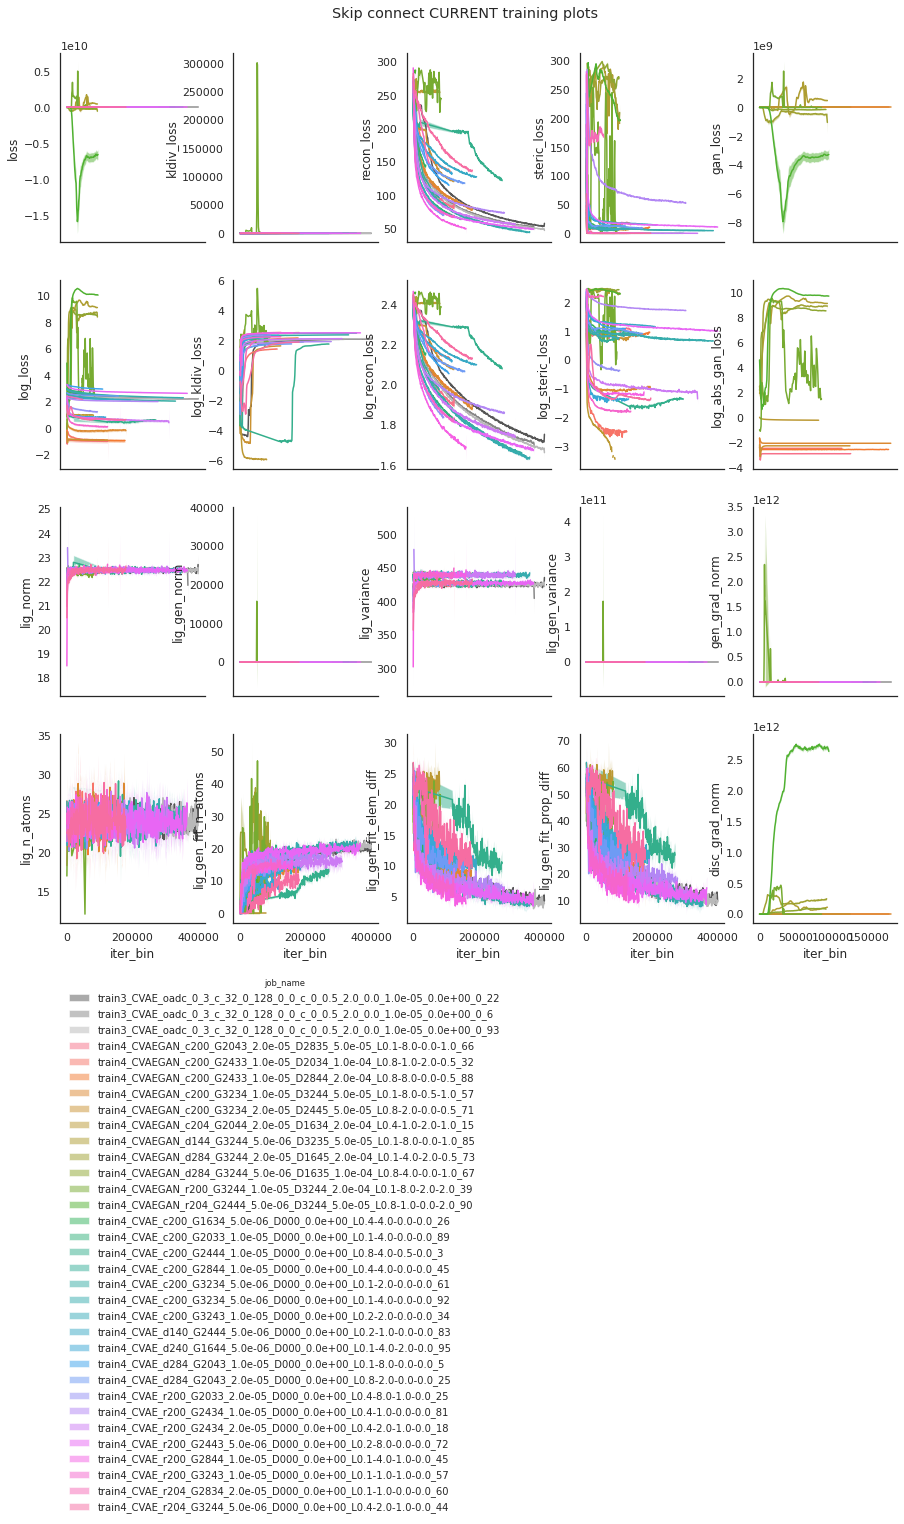

In [191]:
%%time

# plot currently running jobs
hue = 'job_name'
fig = param_search.plot(
    plot_df[
        (
            plot_df['job_name'].isin(running_jobs['job_name']) |
            (plot_df['group_name'] == '3')
        ) &
        ~(plot_df['recon_loss'] > 300) &
        ~(plot_df['steric_loss'] > 300) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Skip connect CURRENT training plots', y=0.92)
fig.savefig('plots/train4_curr_training_plots.png')

In [192]:
name_format

'train{group_name}_{model_type}_{block_type}{width_factor}{growth_rate}{bn_factor}_G{gen_n_filters}{gen_n_levels}{gen_conv_per_level}_{gen_lr:.1e}_D{disc_n_filters}{disc_n_levels}{disc_conv_per_level}_{disc_lr:.1e}_L{kldiv_loss_wt}-{recon_loss_wt}-{steric_loss_wt}-{gan_loss_wt}_{random_seed}'

In [398]:
%%time

# get average metrics for each job name at each iteration bin
df = train_metrics[
    (train_metrics['data_phase'] == 'test')
].groupby(['group_name', 'job_name', 'iter_bin']).mean()

# get WORST metrics across diff seeds of best train3 model, by iter_bin
max_train3_df = df.loc['3'].reset_index().groupby('iter_bin').max()

# get metrics at last iter_bin of each train4 job
last_train4_df = df.loc['4'].reset_index().groupby(['job_name']).last() \
    .reset_index().set_index('iter_bin')

last_train4_df['recon_loss_diff'] = (
    last_train4_df['recon_loss'] - max_train3_df.loc[last_train4_df.index]['recon_loss']
)
# select train4 jobs whose last recon_loss is better than best train3 jobs at same iter_bin
best_train4_jobs = last_train4_df[last_train4_df['recon_loss_diff'] < 0]
best_train4_jobs.reset_index()[['iter_bin', 'recon_loss_diff', 'job_name']].sort_values('iter_bin')

CPU times: user 3.91 s, sys: 426 ms, total: 4.33 s
Wall time: 4.33 s


,iter_bin,recon_loss_diff,job_name
14,29000,-104.536339,train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3
3,38000,-62.569192,train4_CVAE_c200_G1634_5.0e-06_D000_0.0e+00_L0.4-4.0-0.0-0.0_26
16,48000,-16.532940,train4_CVAE_r204_G2834_2.0e-05_D000_0.0e+00_L0.1-1.0-0.0-0.0_60
5,79000,-25.212835,train4_CVAE_c200_G2844_1.0e-05_D000_0.0e+00_L0.4-4.0-0.0-0.0_45
8,91000,-39.761497,train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34
10,93000,-46.118941,train4_CVAE_r200_G2033_2.0e-05_D000_0.0e+00_L0.4-8.0-1.0-0.0_25
15,124000,-39.946526,train4_CVAE_r200_G3243_1.0e-05_D000_0.0e+00_L0.1-1.0-1.0-0.0_57
0,125000,-13.155656,train4_CVAEGAN_c200_G2043_2.0e-05_D2835_5.0e-05_L0.1-8.0-0.0-1.0_66
4,146000,-26.346269,train4_CVAE_c200_G2033_1.0e-05_D000_0.0e+00_L0.1-4.0-0.0-0.0_89
13,161000,-40.637938,train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45


In [194]:
# which of the best train4 jobs are NOT currently running and why?
train_jobs[
    train_jobs['job_name'].isin(best_train4_jobs['job_name']) &
    ~train_jobs['job_name'].isin(running_jobs['job_name']) &
    True
].set_index(['group_name', 'job_name', 'job_id'])[
    ['iteration', 'test_recon_loss', 'job_state', 'stderr']
]

iteration  \
group_name job_name                                                       job_id               
4          train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6922085    29999.0   
           train4_CVAE_r200_G1643_1.0e-05_D000_0.0e+00_L0.2-4.0-0.0-0.0_2 6922123   205866.0   
           train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6970654        NaN   

                                                                                   test_recon_loss  \
group_name job_name                                                       job_id                     
4          train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6922085              NaN   
           train4_CVAE_r200_G1643_1.0e-05_D000_0.0e+00_L0.2-4.0-0.0-0.0_2 6922123             59.0   
           train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6970654              NaN   

                                                                                  job_state  \
group_name job_name                                                       job_id              
4          train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6922085       ERR   
           train4_CVAE_r200_G1643_1.0e-05_D000_0.0e+00_L0.2-4.0-0.0-0.0_2 6922123       ERR   
           train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6970654       ERR   

                                                                                                                                                                                stderr  
group_name job_name                                                       job_id                                                                                                        
4          train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6922085  /var/lib/slurm-llnl/slurmd/job6922085/slurm_script: line 61: 22974 Killed                  pytho...  
           train4_CVAE_r200_G1643_1.0e-05_D000_0.0e+00_L0.2-4.0-0.0-0.0_2 6922123  /var/lib/slurm-llnl/slurmd/job6922123/slurm_script: line 61: 54214 Killed                  pytho...  
           train4_CVAE_r200_G3233_2.0e-05_D000_0.0e+00_L0.4-2.0-0.5-0.0_3 6970654       RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [61]:
# resubmit the best_train4 jobs that errored out, for whatever reason
resub_job_files = train_jobs[
    ~(train_jobs['job_state'] == 'R') &
    train_jobs['job_name'].isin(best_train4_jobs['job_name'].unique())
]['job_file'].unique()

#param_search.submit(resub_job_files)

[6970651,
 6970652,
 6970653,
 6970654,
 6970655,
 6970656,
 6970657,
 6970658,
 6970659,
 6970660]

In [401]:
colors = get_palette(
    n_hues=1,
    n_shades=3,
    max_val=0.5,
    mode='Greys'
) + get_palette(
    n_hues=4,
    n_shades=[3, 6, 8],
    mode='husl',
    min_val=0.1,
    max_val=0.9
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.33779803778975315, 0.3377954651763291, 0.3378291746614944),
 (0.5309455919063597, 0.5309438590579394, 0.530966564928776),
 (0.7240931460229663, 0.7240922529395497, 0.7241039551960577),
 (0.6481200100189586, 0.316624000033369, 0.3751317774356173),
 (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9613893949076647, 0.635390579429568, 0.6936132620310566),
 (0.40277342233791635, 0.33855031269675995, 0.15991399791236457),
 (0.5347629402904549, 0.4405356367456877, 0.17363056707262814),
 (0.664476776898984, 0.5407625931385994, 0.18711064366116303),
 (0.7570994857018675, 0.6306819496528111, 0.269297638658773),
 (0.8054981575057116, 0.7083114755424189, 0.4334044209902802),
 (0.8547459288148863, 0.7873029229388621, 0.6003902696784805),
 (0.2012727576778421, 0.35154541773540426, 0.15543305447085165),
 (0.23379799668909534, 0.45118834962874277, 0.16621603051074454),
 (0.26632323570034855, 0.5508312815220813, 0.1769990065506374),
 (0.29884847471160175, 0.6504742134154198, 0.18778198259053028),
 (0.34860321969646324, 0.708105500627918, 0.2351226003775123),
 (0.46113443530069165, 0.7558262913692941, 0.3690792347235321),
 (0.57366565090492, 0.8035470821106704, 0.5030358690695519),
 (0.6861968665091485, 0.8512678728520466, 0.6369925034155717)]

CPU times: user 1min, sys: 30.9 s, total: 1min 31s
Wall time: 1min 32s


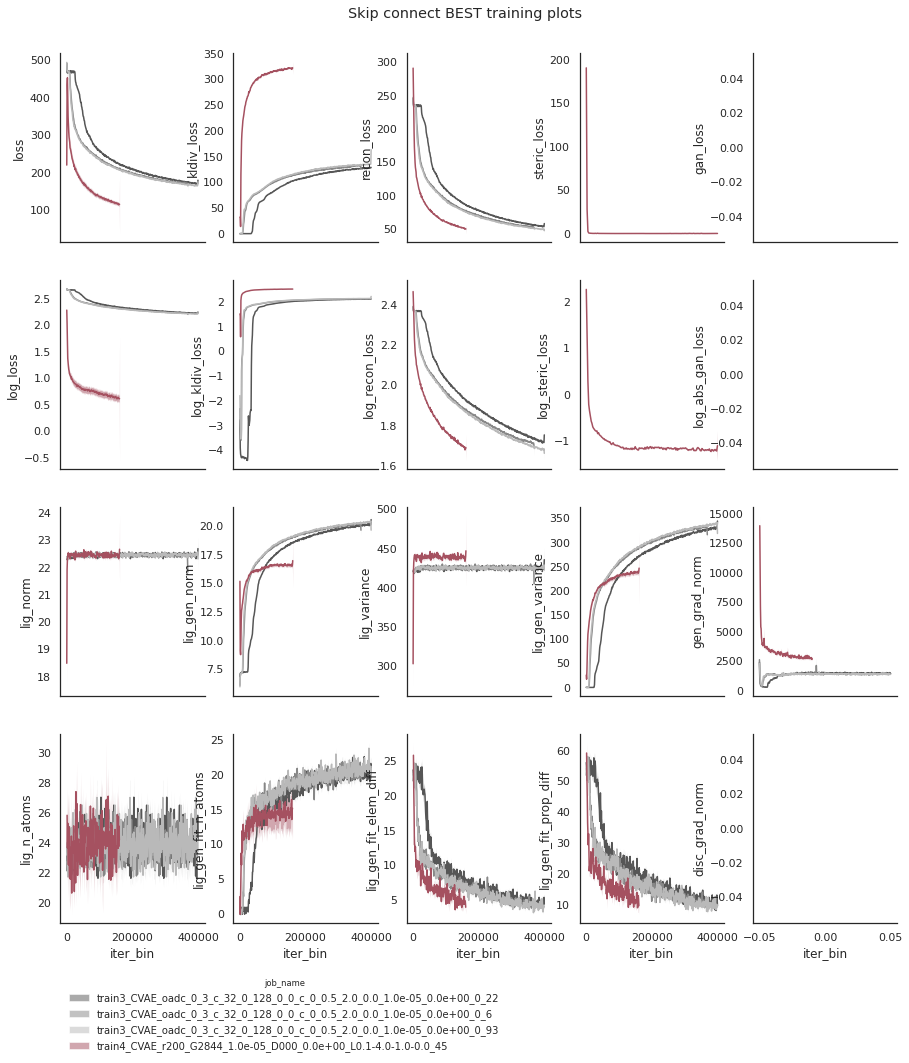

In [402]:
%%time
hue = 'job_name'

# plot best train4 jobs
fig = param_search.plot(
    plot_df[
        (
            (
                (plot_df['job_name'] == 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45') &
                #plot_df['job_name'].isin(best_train4_jobs['job_name']) &
                #~plot_df['job_name'].isin(running_jobs['job_name']) &
                True
            ) | (plot_df['group_name'] == '3')
        ) &
        ~(plot_df['recon_loss'] > 300) &
        ~(plot_df['steric_loss'] > 300) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Skip connect BEST training plots', y=0.92)
fig.savefig('plots/train4_best_training_plots.png')

In [197]:
name_format

'train{group_name}_{model_type}_{block_type}{width_factor}{growth_rate}{bn_factor}_G{gen_n_filters}{gen_n_levels}{gen_conv_per_level}_{gen_lr:.1e}_D{disc_n_filters}{disc_n_levels}{disc_conv_per_level}_{disc_lr:.1e}_L{kldiv_loss_wt}-{recon_loss_wt}-{steric_loss_wt}-{gan_loss_wt}_{random_seed}'

In [198]:
best_train4_jobs.sort_values('recon_loss')

,job_name,iteration,batch,loss,recon_loss,kldiv_loss,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_fit_n_atoms,lig_gen_fit_radius,lig_n_atoms,lig_radius,lig_gen_fit_type_diff,lig_gen_fit_exact_types,lig_gen_fit_elem_diff,lig_gen_fit_exact_elems,lig_gen_fit_prop_diff,lig_gen_fit_exact_props,lig_gen_fit_atom_rmsd,forward_data_time,forward_gen_time,forward_fit_time,forward_metrics_time,forward_time,forward_gpu,memory,gen_grad_norm,backward_time,backward_grad_time,backward_norm_time,backward_update_time,backward_gpu,use_rec_elems,radius_fn,gen_init_conv_pool,gen_conv_per_level,gen_n_filters,gen_spectral_norm,n_latent,kldiv_loss_wt,recon_loss_wt,gen_lr,gen_grad_clip,disc_grad_clip,n_gen_train_iters,gen_iteration,disc_init_conv_pool,disc_conv_per_level,disc_n_filters,n_disc_train_iters,disc_lr,gan_loss_wt,random_seed,disc_iter,steric_loss,forward_disc_time,batch_size,bn_factor,steric_loss_wt,gen_k_iter,gen_n_levels,growth_rate,width_factor,disc_n_levels,gan_loss,disc_pred_mean,disc_pred_variance,pred_mean,pred_variance,disc_grad_norm,log_loss,log_kldiv_loss,log_recon_loss,log_steric_loss,log_abs_gan_loss
iter_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
355000,train4_CVAE_c200_G3234_5.0e-06_D000_0.0e+00_L0.1-4.0-0.0-0.0_92,355150.0,4.5,210.318195,44.818638,310.436408,22.226266,432.984187,20.464332,357.748884,44.818638,19.8700,6.030120,22.3500,6.100942,11.480,0.08,3.5800,0.1200,7.9000,0.09,NaN,0.059272,0.025112,1.641618,0.005430,1.836846,5280.004956,21828.302734,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,1.0,4.0,32.0,1.0,128.0,0.1,4.0,0.000005,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00000,0.0,92.0,0.0,4.963736,0.104371,10.0,0.0,0.0,100.0,3.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.313271,2.490984,1.638930,0.683272,NaN
331000,train4_CVAE_c200_G3234_5.0e-06_D000_0.0e+00_L0.1-2.0-0.0-0.0_61,331150.0,4.5,122.278354,48.789996,246.983614,22.632848,448.342290,20.681448,365.185828,48.789996,20.6300,6.104563,23.7200,6.166927,13.130,0.07,3.8900,0.1300,9.2400,0.09,NaN,0.045585,0.024171,1.689938,0.005317,1.870200,5278.097498,24440.189941,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,1.0,4.0,32.0,1.0,128.0,0.1,2.0,0.000005,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00000,0.0,61.0,0.0,4.992983,0.104336,10.0,0.0,0.0,100.0,3.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.075576,2.391378,1.671803,0.674527,NaN
161000,train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45,161000.0,4.5,115.517672,49.612444,322.080200,22.672894,447.036053,16.959889,246.772529,49.612442,15.1500,5.213970,24.2200,6.484407,13.580,0.04,3.9200,0.1400,9.6600,0.08,NaN,0.103732,0.036311,5.680697,0.006534,5.924747,9599.235791,42491.219141,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,0.0,4.0,28.0,1.0,128.0,0.1,4.0,0.000010,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00000,0.0,45.0,0.0,0.188773,0.095680,10.0,0.0,1.0,100.0,4.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.613700,2.507650,1.691025,-1.100630,NaN
367000,train4_CVAE_r200_G2443_5.0e-06_D000_0.0e+00_L0.2-8.0-0.0-0.0_72,367200.0,4.5,497.535604,53.911406,331.221779,22.844423,444.512071,20.534387,350.143065,53.911406,20.8000,6.291238,25.2875,6.506950,20.400,0.05,5.6625,0.1125,14.7375,0.05,NaN,0.041643,0.024360,1.090139,0.004025,1.242915,6507.508906,45678.407031,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,0.0,3.0,24.0,1.0,128.0,0.2,8.0,0.000005,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00000,0.0,72.0,0.0,9.213489,0.081672,8.0,0.0,0.0,100.0,4.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.685770,2.519623,1.717615,0.927448,NaN
311000,train4_CVAE_r200_G2434_2.0e-05_D000_0.0e+00_L0.4-2.0-1.0-0.0_18,311000.0,4.5,83.402614,56.156149,135.958104,22.327335,438.784564,17.692215,265.039919,56.156149,16.2000,5.381494,23.8200,6.260506,17.120,0.06,4.8400,0.1000,12.2800,0.06,NaN,0.064121,0.024777,5.601967,0.007571,5.851093,5248.366748,33726.356641,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,1.0,4.0,24.0,1.0,128.0,0.4,2.0,0.000020,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.00000,0.0,18.0,0.0,0.054843,0.151218,10.0,0.0,1.0,100.0,3.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.426674,2.131447,1.7

In [203]:
colors = get_palette(
    n_hues=1,
    n_shades=3,
    max_val=0.5,
    mode='Greys'
) + get_palette(
    n_hues=20,
    n_shades=1,
    mode='husl'
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.33779803778975315, 0.3377954651763291, 0.3378291746614944),
 (0.5309455919063597, 0.5309438590579394, 0.530966564928776),
 (0.7240931460229663, 0.7240922529395497, 0.7241039551960577),
 (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9704241569984234, 0.4603475375001678, 0.3099359864545268),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.7632105624545802, 0.5838460616396939, 0.19465686802007026),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.19316929744982803, 0.7018418078239693, 0.24321388407365968),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.20631516405196249, 0.6834948167725491, 0.5761817437653648),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21461147568939787, 0.6708637556281021, 0.7042594890626992),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.22829030785596155, 0.6480515334381642, 0.8744997507366618),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.9579148533500138, 0.358831186992106, 0.9474115985773391),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775),
 (0.9651791951613143, 0.4212549802305815, 0.6785112441648762)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CPU times: user 1min 56s, sys: 1min 3s, total: 2min 59s
Wall time: 2min 59s


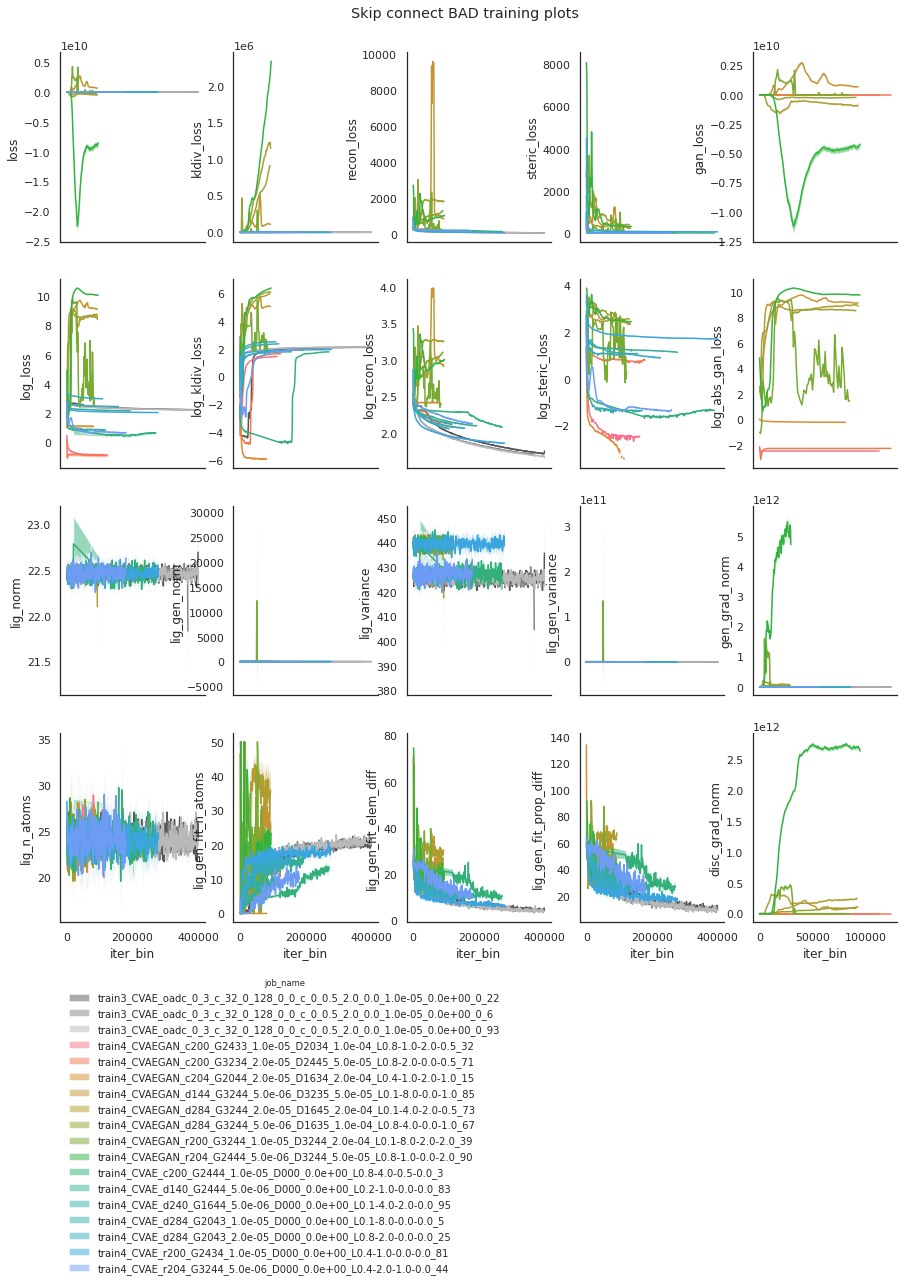

In [204]:
%%time

# plot running jobs that are NOT promising
hue = 'job_name'
fig = param_search.plot(
    plot_df[
        (
            (
                ~plot_df['job_name'].isin(best_train4_jobs['job_name'].unique()) &
                plot_df['job_name'].isin(running_jobs['job_name'].unique())
                
            ) | (plot_df['group_name'] == '3')
        ) &
        ~(plot_df['log_recon_loss'] > 4) &
        ~(plot_df['log_steric_loss'] > 4) &
        True
    ].sort_values(hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(0.00, -0.25),
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
fig.suptitle('Skip connect BAD training plots', y=0.92)
fig.savefig('plots/train4_bad_training_plots.png')

In [62]:
# cancel all running jobs that are not promising
cancel_job_ids = train_jobs[
    (train_jobs['job_state'] == 'R') &
    ~train_jobs['job_name'].isin(best_train4_jobs['job_name'].unique())
]['job_id'].unique()

#param_search.cancel(cancel_job_ids)

''

In [205]:
# verify that no currently-loaded train4 jobs have been submit more than once
train4_jobs = train_jobs[train_jobs['group_name'] == 4]
train4_jobs.groupby('job_name')['job_id'].count().unique()

array([1, 2])

In [92]:
# get jobs whose latest submission ran out of CUDA memory
#   and determine how much memory to request on resubmit

def get_sbatch_line(cuda_mem):
    cuda_mem = cuda_mem + 2
    if cuda_mem > 24:
        cuda_req = 'A100'
    elif cuda_mem > 16:
        cuda_req = 'M24'
    elif cuda_mem > 12:
        cuda_req = 'M16'
    elif cuda_mem > 8:
        cuda_req = 'M12'
    else:
        return ' '
    return '#SBATCH -C ' + cuda_req

cuda_oom_jobs = train4_jobs[
    train4_jobs['stderr'].astype(str).str.contains('CUDA out of memory')
]
cuda_oom_jobs['cuda_mem'] = cuda_oom_jobs['stderr'].map(
    lambda x: float(re.search('(\S+) GiB total capacity', x).group(1))
)
cuda_oom_jobs['sbatch_line'] = cuda_oom_jobs['cuda_mem'].map(get_sbatch_line)

cuda_oom_jobs.set_index(['job_name', 'job_id']) \
[[
    'job_state', 'iteration', 'stderr', 'cuda_mem', 'sbatch_line'
]]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,,job_state,iteration,stderr,cuda_mem,sbatch_line
job_name,job_id,,,,,
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45,6922074,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 120.00 MiB (GPU 0; 10.76 GiB total capacity;...,10.76,#SBATCH -C M16
train4_CVAE_d240_G1644_5.0e-06_D000_0.0e+00_L0.1-4.0-2.0-0.0_95,6922089,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 76.00 MiB (GPU 0; 7.93 GiB total capacity; 6...,7.93,#SBATCH -C M12
train4_CVAE_r204_G3244_5.0e-06_D000_0.0e+00_L0.4-2.0-1.0-0.0_44,6922099,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 10.76 GiB total capacity;...,10.76,#SBATCH -C M16
train4_CVAEGAN_r200_G3244_1.0e-05_D3244_2.0e-04_L0.1-8.0-2.0-2.0_39,6922101,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 11.78 GiB total capacity; ...,11.78,#SBATCH -C M16
train4_CVAEGAN_d144_G3244_5.0e-06_D3235_5.0e-05_L0.1-8.0-0.0-1.0_85,6922102,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 136.00 MiB (GPU 0; 11.78 GiB total capacity;...,11.78,#SBATCH -C M16
train4_CVAEGAN_r204_G2444_5.0e-06_D3244_5.0e-05_L0.8-1.0-0.0-2.0_90,6922117,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 11.91 GiB total capacity; ...,11.91,#SBATCH -C M16
train4_CVAE_d284_G2043_1.0e-05_D000_0.0e+00_L0.1-8.0-0.0-0.0_5,6922118,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 7.93 GiB total capacity; 7...,7.93,#SBATCH -C M12
train4_CVAE_r200_G3243_1.0e-05_D000_0.0e+00_L0.1-1.0-1.0-0.0_57,6922120,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 7...,7.93,#SBATCH -C M12
train4_CVAE_d284_G2043_2.0e-05_D000_0.0e+00_L0.8-2.0-0.0-0.0_25,6922122,ERR,NaN,RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 7.93 GiB total capacity; ...,7.93,#SBATCH -C M12


In [100]:
name_format

'train{group_name}_{model_type}_{typer_fns}_{gen_init_conv_pool}_{gen_conv_per_level}_{gen_block_type}_{gen_n_filters}_{gen_spectral_norm}_{n_latent}_{disc_init_conv_pool}_{disc_conv_per_level}_{disc_block_type}_{disc_n_filters}_{kldiv_loss_wt}_{recon_loss_wt}_{gan_loss_wt}_{gen_lr:.1e}_{disc_lr:.1e}_{n_disc_train_iters}_{random_seed}'

In [106]:
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [110]:
def setup_cuda_oom_job(args):
    job_file = args['job_file']
    sbatch_line = args['sbatch_line']
    
    params = param_search.params.Params.from_file(
        job_file, line_start='# '
    )
    params['sbatch_line'] = sbatch_line
    
    for template_file in ['train.config', 'train.sh']:
        new_job_file = param_search.setup(
            expt_dir='.',
            name_format=name_format,
            template_file=template_file,
            param_space=[params]
        )[0]

    assert new_job_file == './'+job_file
    

cuda_oom_jobs[['job_file', 'sbatch_line']].apply(setup_cuda_oom_job, axis=1)

param_search.submit(cuda_oom_jobs['job_file'], verbose=True)

[6970667,
 6970668,
 6970669,
 6970670,
 6970671,
 6970672,
 6970673,
 6970674,
 6970675,
 6970676,
 6970677,
 6970678,
 6970679,
 6970680,
 6970681,
 6970682,
 6970683,
 6970684,
 6970685]

In [274]:
param_cols = [
       'data_root', 'train_file', 'test_file',
       'batch_size', 'typer_fns', 'use_rec_elems', 'radius_fn',
       'gen_n_filters', 'gen_conv_per_level', 'bn_factor', 'gen_spectral_norm',
       'n_latent', 'skip_connect', 'kldiv_loss_wt', 'recon_loss_wt',
       'steric_loss_wt', 'optim_type', 'gen_lr', 'gen_grad_clip',
       'disc_grad_clip', 'n_gen_train_iters', 'group_name', 'gen_k_iter',
       'random_seed', 'gen_init_conv_pool', 'gen_n_levels', 'block_type',
       'growth_rate', 'width_factor', 'model_type', 'disc_init_conv_pool',
       'disc_n_levels', 'disc_conv_per_level', 'disc_n_filters',
       'n_disc_train_iters', 'disc_lr', 'gan_loss_wt', 'sbatch_line',
]

train4_job_params = train_metrics[
    (train_metrics['group_name'] == '4')
].groupby(['job_name'] + param_cols).mean().reset_index()

train4_job_params['is_better_than_train3'] = train4_job_params['job_name'].map(
    set(best_train4_jobs['job_name'].unique()).__contains__
).astype(int)

#train4_job_params.to_csv('train4_job_params.csv')

In [317]:
df = train4_job_params
df['gen_n_conv_layers'] = df['gen_conv_per_level']*df['gen_n_levels'] \
    - df['gen_init_conv_pool']*(df['gen_conv_per_level'] - 1)
df['disc_n_conv_layers'] = df['disc_conv_per_level']*df['disc_n_levels'] \
    - df['disc_init_conv_pool']*(df['disc_conv_per_level'] - 1)
df['gen_conv_volume'] = df['gen_n_filters']*df['gen_n_conv_layers']
df['disc_conv_volume'] = df['disc_n_filters']*df['disc_n_conv_layers']
df['disc_gen_depth_ratio'] = df['disc_n_conv_layers'] / df['gen_n_conv_layers']
df['disc_gen_width_ratio'] = df['disc_n_filters'] / df['gen_n_filters']
df['disc_gen_volume_ratio'] = df['disc_conv_volume'] / df['gen_conv_volume']
df['disc_gen_lr_ratio'] = df['disc_lr'] / df['gen_lr']
df['loss_wt_sum'] = df['kldiv_loss_wt'] + df['recon_loss_wt'] + df['steric_loss_wt'] + df['gan_loss_wt']
df['loss_wt_norm'] = (df['kldiv_loss_wt']**2 * df['recon_loss_wt']**2 * df['steric_loss_wt']**2 * df['gan_loss_wt']**2)**0.5

interact_cols = [
    'gen_n_conv_layers', 'gen_conv_volume', 'disc_n_conv_layers', 'disc_conv_volume',
    'disc_gen_depth_ratio', 'disc_gen_width_ratio', 'disc_gen_volume_ratio', 'disc_gen_lr_ratio',
    'loss_wt_sum', 'loss_wt_norm'
]

In [372]:
n_shades = 1
colors = sum([list(t) for t in zip(
    sns.color_palette('Blues', n_shades),
    sns.color_palette('Greens', n_shades),
    sns.color_palette('Reds', n_shades)
)], [])
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),
 (0.45176470588235296, 0.7670895809304115, 0.4612072279892349),
 (0.9835755478662053, 0.4127950788158401, 0.28835063437139563)]

CPU times: user 3.64 s, sys: 327 ms, total: 3.97 s
Wall time: 3.85 s


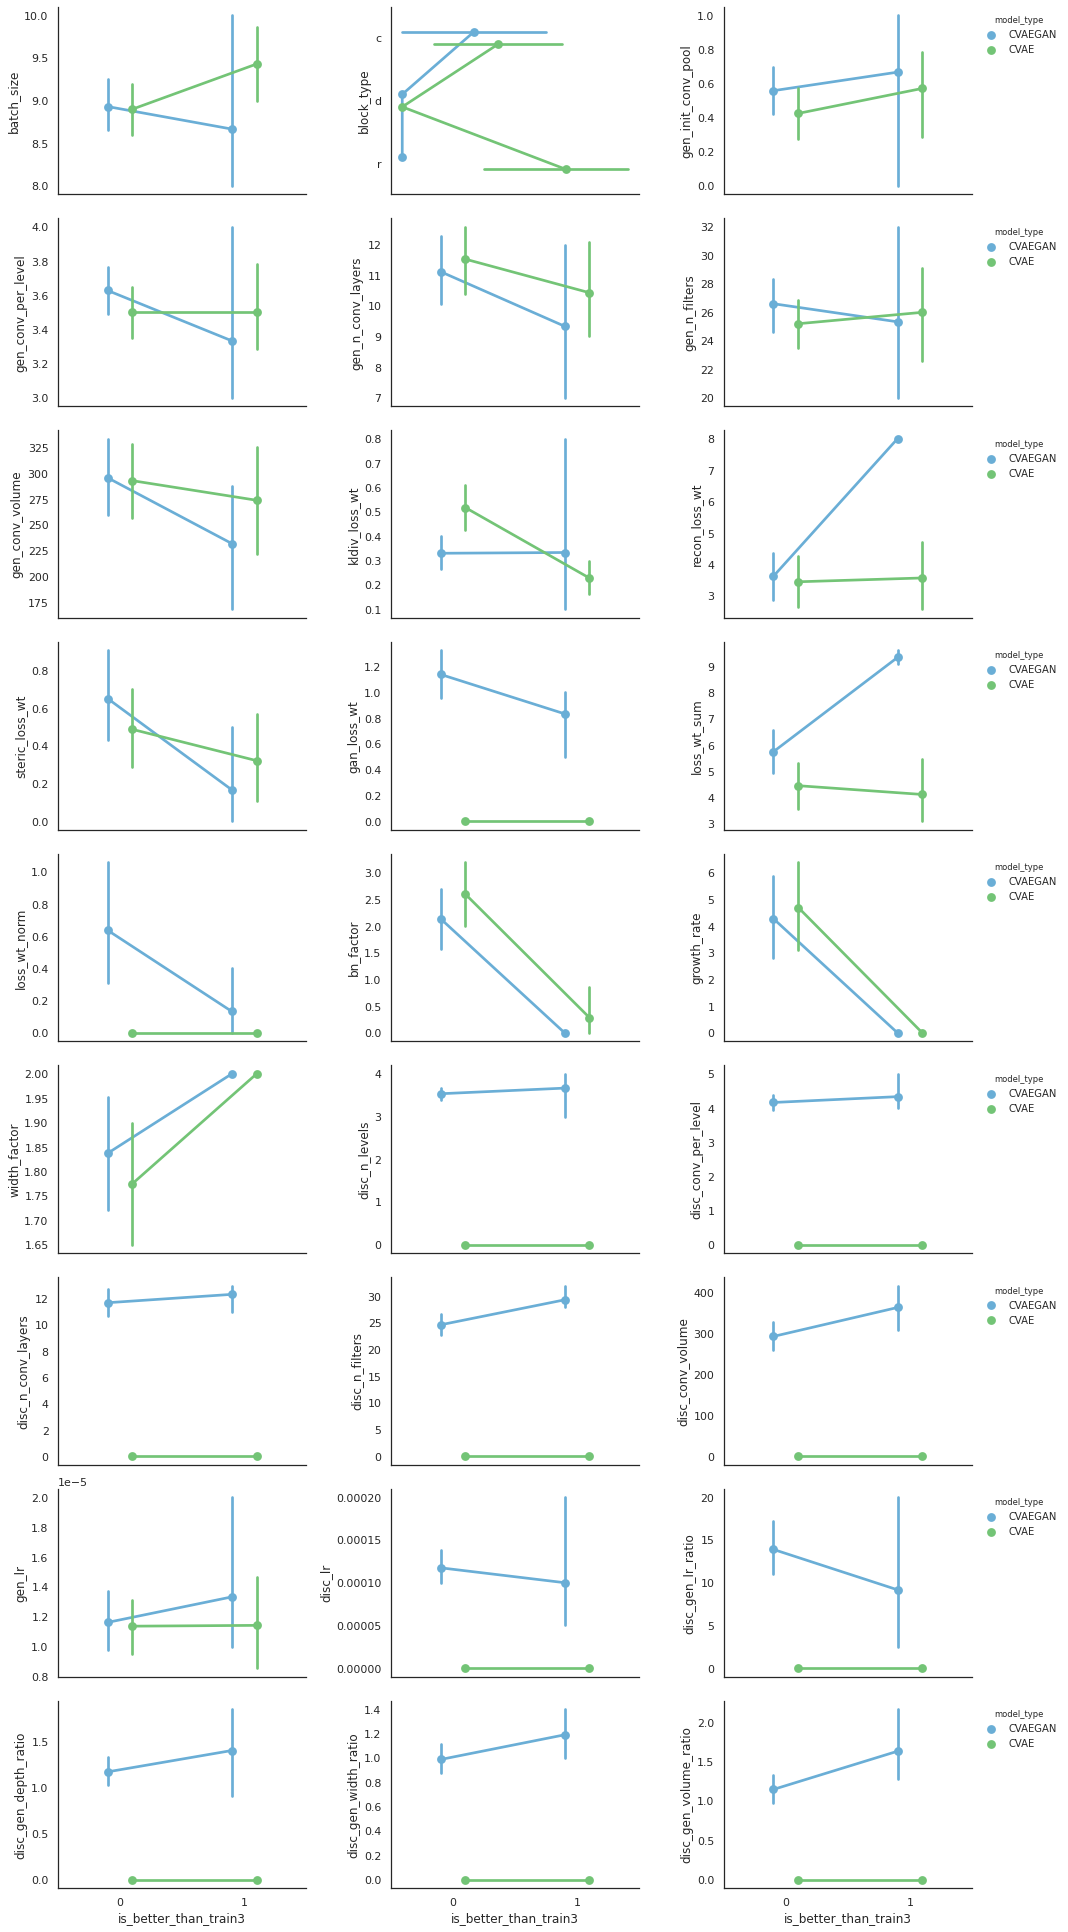

In [373]:
%%time

train4_job_params['is_better_than_train3'] = train4_job_params['is_better_than_train3'].astype(int)

hue =['model_type']
x = ['is_better_than_train3']
y = [
    'batch_size',
    'block_type',
    'gen_init_conv_pool',
    'gen_conv_per_level',
    'gen_n_conv_layers',
    'gen_n_filters',
    'gen_conv_volume',
    
    'kldiv_loss_wt',
    'recon_loss_wt',
    'steric_loss_wt',
    'gan_loss_wt',
    'loss_wt_sum',
    'loss_wt_norm',
    
    'bn_factor',
    'growth_rate',
    'width_factor',
    
    'disc_n_levels',
    'disc_conv_per_level',
    'disc_n_conv_layers',
    'disc_n_filters',
    'disc_conv_volume',
    
    'gen_lr',
    'disc_lr',
    'disc_gen_lr_ratio',
    
    'disc_gen_depth_ratio',
    'disc_gen_width_ratio',
    'disc_gen_volume_ratio',
]

fig = param_search.plot(
    train4_job_params,
    x=x,
    y=y,
    hue=hue,
    n_cols=3,
    width=5,
    height=3,
    plot_func=sns.pointplot,
    plot_kws=dict(dodge=0.2),
    ylim=dict(is_better_than_train3=[0, 1]),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(1.00, 1.00),
    ),
    legend=True,
    legend_row=None,
    legend_col=-1,
    tight=True,
)
#fig.suptitle('Skip connect parameter plots', y=0.885)
fig.savefig('plots/train4_param_plots.png')

In [297]:
plot_df.apply(make_ordinal)

[2e-05, 1e-05, 5e-06]
[5e-05, 0.0001, 0.0002, 0.0]
['1', '0']


,gen_lr,disc_lr,is_better_than_train3
0,0.0,0.000000,0.0
1,0.5,0.333333,1.0
2,0.5,0.666667,0.0
3,0.5,0.000000,0.0
4,0.0,0.000000,1.0
5,0.5,0.666667,1.0
6,1.0,0.666667,1.0
7,0.0,0.666667,1.0
8,1.0,0.333333,1.0
9,0.5,0.000000,1.0


model_type ['CVAE', 'CVAEGAN']
block_type ['c', 'd', 'r']
batch_size [8.0, 10.0]
gen_init_conv_pool [0, 1]
gen_conv_per_level [3, 4]
gen_n_conv_layers [7.0, 9.0, 12.0, 16.0]
gen_n_filters [16, 20, 24, 28, 32]
gen_conv_volume [112.0, 140.0, 144.0, 168.0, 180.0, 192.0, 196.0, 216.0, 224.0, 240.0, 252.0, 256.0, 288.0, 320.0, 336.0, 384.0, 448.0, 512.0]
kldiv_loss_wt [0.1, 0.2, 0.4, 0.8]
recon_loss_wt [1.0, 2.0, 4.0, 8.0]
steric_loss_wt [0.0, 0.5, 1.0, 2.0]
gan_loss_wt [0.0, 0.5, 1.0, 2.0]
loss_wt_sum [1.1, 1.2, 1.4, 1.8, 1.9, 2.1, 2.2, 2.4, 2.7, 2.8, 2.9, 3.1, 3.2, 3.3, 3.4, 3.6, 3.8, 3.9, 4.1, 4.2, 4.3, 4.4, 4.6, 4.7, 4.8, 4.9, 5.1, 5.2, 5.3, 5.4, 5.8, 6.1, 6.2, 6.6, 6.7, 6.9, 7.2, 7.3, 8.1, 8.2, 8.8, 9.1, 9.2, 9.3, 9.4, 9.6, 10.2, 10.9, 12.1, 12.2]
loss_wt_norm [0.0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
bn_factor [0.0, 4.0]
growth_rate [0.0, 4.0, 8.0, 16.0]
width_factor [1.0, 2.0]
disc_n_levels [0.0, 3.0, 4.0]
disc_conv_per_level [0, 3, 4, 5]
disc_n_conv_layers [0.0, 7.0, 9.0, 10.0, 11.0,

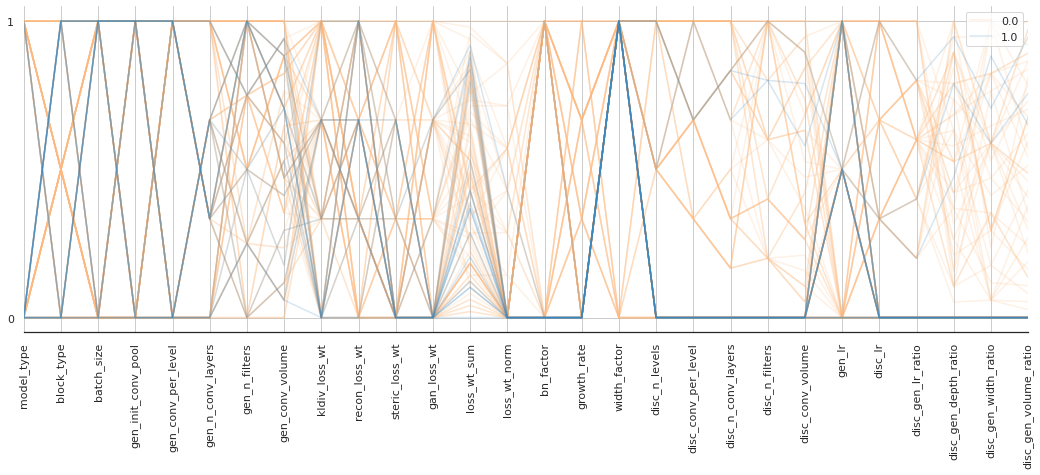

In [368]:
cols = hue + y + ['is_better_than_train3']

plot_df = train4_job_params[cols].copy()

def make_ordinal(col):
    col_values = sorted(col.unique())
    print(col.name, col_values)
    return col.map(col_values.index) / (len(col_values) - 1)

plot_df['is_better_than_train3'] = plot_df['is_better_than_train3'].astype(int)
plot_df = plot_df.apply(make_ordinal)

fig, ax = plt.subplots(figsize=(18,6))
_ = pd.plotting.parallel_coordinates(
    plot_df.sort_values('is_better_than_train3'),
    class_column=cols[-1],
    cols=cols[:-1],
    color=sns.color_palette('Oranges', 2)[0:1] + sns.color_palette('Blues', 2)[1:2],
    axvlines=False,
    alpha=0.2,
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticks([0, 1])
sns.despine(fig, left=True)

In [ ]:
time_cols = ['forward_data_time', 'forward_gen_time', 'forward_fit_time', 'forward_metrics_time', 'forward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
plot_df = (plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

In [ ]:
time_cols = ['backward_grad_time', 'backward_norm_time', 'backward_update_time', 'backward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
(plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

In [ ]:
train_metrics.to_csv('train2_100k_backup.train_metrics')

In [ ]:
save_cols = 'iteration data_phase batch loss recon_loss kldiv_loss lig_norm lig_variance lig_gen_norm lig_gen_variance lig_gen_L2_loss lig_gen_fit_n_atoms lig_gen_fit_radius lig_n_atoms lig_radius lig_gen_fit_type_diff lig_gen_fit_exact_types lig_gen_fit_atom_rmsd forward_data_time forward_gen_time forward_fit_time forward_metrics_time forward_time forward_gpu memory'.split(' ')
for job_name, job_metrics in train_metrics.groupby('job_name'):
    metrics_file = job_name + '/' + job_name + '.train_metrics'
    job_metrics[save_cols].to_csv(metrics_file, sep=' ', header=True, index=False)
    print(metrics_file)